In [1]:
### Calibrate camera
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
from calibrate_cam import calibrate_camera
from get_perspective import get_perspective

# constants
ym_per_px = 30/720*0.3121591191584172 # meters per pixel in y dimension (using real AR)
xm_per_px = 3.7/700 # meters per pixel in x dimension

nx = 9
ny = 6
calibration_images = sorted(glob.glob('./camera_cal/*.jpg'))
test_images = sorted(glob.glob('./test_images/*.jpg'))
img = cv2.imread('test_images/test5.jpg')
mtx, dist = calibrate_camera(calibration_images, nx, ny)


In [2]:
if not os.path.isdir('output_images\\undistorted'):
    os.mkdir('output_images\\undistorted')

if not os.path.isdir('output_images\\binary'):
    os.mkdir('output_images\\binary')

if not os.path.isdir('output_images\\perspective'):
    os.mkdir('output_images\\perspective')

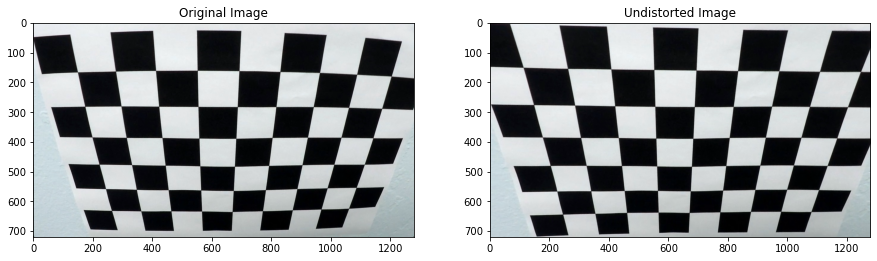

In [3]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(30, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L_channel = lab[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    #Threshold LAB
    labbinary = np.zeros_like(L_channel)
    labbinary[(L_channel >= 100) & (L_channel <= 255)] = 1
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    img_bwa = cv2.bitwise_and(labbinary,s_binary)
    
    t_binary = np.zeros(img.shape[:2], dtype=np.uint8)
    t_binary[(L_channel >= 100) & (s_binary <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), np.zeros_like(sxbinary), img_bwa + sxbinary)) * 255
    return color_binary

### Undistort all the images
for filename in os.listdir("test_images"):
    image_dir = os.path.join('test_images', filename)
    image = cv2.imread(image_dir)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    undist_output = os.path.join('output_images\\undistorted', filename)
    cv2.imwrite(undist_output, undist)
    
    binary = pipeline(undist)
    binary_output = os.path.join('output_images\\binary', filename)
    cv2.imwrite(binary_output, binary)
    
    perspec, M, Minv = get_perspective(binary)
    gray = cv2.cvtColor(perspec, cv2.COLOR_BGR2GRAY)
    (thresh, blackAndWhiteImage) = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    perspec_output = os.path.join('output_images\\perspective', filename)
    cv2.imwrite(perspec_output, blackAndWhiteImage)

orig = cv2.imread('camera_cal/calibration2.jpg')
und = cv2.undistort(orig, mtx, dist, None, mtx)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(orig)
ax1.set_title("Original Image")
ax2.imshow(und)
ax2.set_title("Undistorted Image")
plt.savefig('output_images/undistorted.jpg', bbox_inches='tight')

In [4]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def compute_lane_curvature(leftx, rightx, ploty, cols, y0):
        """
        Returns the triple (left_curvature, right_curvature, lane_center_offset), which are all in meters
        """        
        # Define conversions in x and y from pixels space to meters
        y_eval = np.max(ploty)
        
        # Fit new polynomials: find x for y in real-world space
        left_fit_cr = np.polyfit(ploty * ym_per_px, leftx * xm_per_px, 2)
        right_fit_cr = np.polyfit(ploty * ym_per_px, rightx * xm_per_px, 2)
        
        # Now calculate the radii of the curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_px + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 *right_fit_cr[0] * y_eval * ym_per_px + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
        
        left = np.polyval(left_fit_cr, y0*ym_per_px)
        right = np.polyval(right_fit_cr, y0*ym_per_px)
        center = cols / 2 * xm_per_px
        offcenter = center - (left + right)/2
        curverad = (left_curverad + right_curverad) / 2
        # Now our radius of curvature is in meters        
        return curverad, offcenter

    
def search_around_poly(binary_warped, Minv, left_fit, right_fit, undist):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    rows, cols = undist.shape[:2]
    y0 = rows-1
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    #result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    curverad, offcenter = compute_lane_curvature(left_fitx, right_fitx, ploty, cols, y0)
    
    
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    left_x_pos = left_fit[0]*y0**2 + left_fit[1]*y0 + left_fit[2]
    right_x_pos = right_fit[0]*y0**2 + right_fit[1]*y0 + right_fit[2]
    center_lanes_x_pos = (left_x_pos + right_x_pos)//2
    offcenter = ((cols//2) - center_lanes_x_pos) * xm_per_px 
    
    
    return result, curverad, offcenter

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

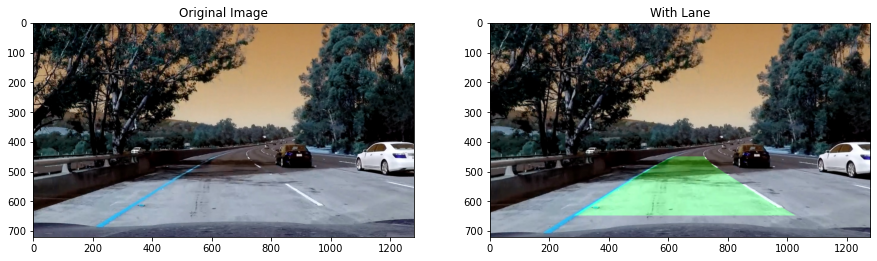

In [8]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    binary = pipeline(undist)
    
    perspec, M, Minv = get_perspective(binary)
    gray = cv2.cvtColor(perspec, cv2.COLOR_BGR2GRAY)
    (thresh, blackAndWhiteImage) = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

    out_img, left_fit, right_fit = fit_polynomial(blackAndWhiteImage)
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    #ax1.imshow(orig)
    #ax1.set_title("Original Image")
    #ax2.imshow(und)
    #ax2.set_title("Undistorted Image")
    #plt.savefig('output_images/undistorted.jpg', bbox_inches='tight')
    result, curverad, offcenter = search_around_poly(blackAndWhiteImage, Minv, left_fit, right_fit, undist)
    img = cv2.putText(result, 'Radius of curvature:', (20,60), cv2.FONT_HERSHEY_SIMPLEX, 1.8, (255, 255, 255), 10, cv2.LINE_AA)
    img = cv2.putText(result, '{0:>10.3f} m'.format(curverad), (700,60), cv2.FONT_HERSHEY_SIMPLEX, 1.8, (255, 255, 255), 10, cv2.LINE_AA)
    img = cv2.putText(result, 'Distance from lane center:', (20,130), cv2.FONT_HERSHEY_SIMPLEX, 1.8, (255, 255, 255), 10, cv2.LINE_AA)
    img = cv2.putText(result, '{0:>+10.3f} m'.format(offcenter), (700,130), cv2.FONT_HERSHEY_SIMPLEX, 1.8, (255, 255, 255), 10, cv2.LINE_AA)
    return result

image = cv2.imread('test_images/test5.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
binary = pipeline(undist)
    
perspec, M, Minv = get_perspective(binary)
gray = cv2.cvtColor(perspec, cv2.COLOR_BGR2GRAY)
(thresh, blackAndWhiteImage) = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

out_img, left_fit, right_fit = fit_polynomial(blackAndWhiteImage)

result, curverad, offcenter = search_around_poly(blackAndWhiteImage, Minv, left_fit, right_fit, undist)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(image)
ax1.set_title("Original Image")
ax2.imshow(result)
ax2.set_title("With Lane")
plt.savefig('examples/with_detected_lane.jpg', bbox_inches='tight')

In [ ]:
white_output = 'project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_out.mp4.
Moviepy - Writing video project_video_out.mp4



t:   4%|▎         | 47/1260 [05:20<4:07:29, 12.24s/it, now=None]

KeyboardInterrupt: 

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [23]:
chal_output = 'challenge_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
chal_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time chal_clip.write_videofile(chal_output, audio=False)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Source:

---------------------------
Destination:

Moviepy - Building video challenge_video_out.mp4.
Moviepy - Writing video challenge_video_out.mp4

Source:

---------------------------
Destination:



t:   1%|          | 3/485 [00:01<03:14,  2.48it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   1%|          | 5/485 [00:01<02:11,  3.66it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   1%|▏         | 7/485 [00:01<01:41,  4.73it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   2%|▏         | 9/485 [00:02<01:24,  5.64it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   2%|▏         | 11/485 [00:02<01:15,  6.29it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   3%|▎         | 13/485 [00:02<01:15,  6.21it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   3%|▎         | 15/485 [00:02<01:13,  6.38it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   4%|▎         | 17/485 [00:03<01:10,  6.66it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   4%|▍         | 19/485 [00:03<01:06,  7.04it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   4%|▍         | 21/485 [00:03<01:03,  7.26it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   5%|▍         | 23/485 [00:04<01:03,  7.32it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   5%|▌         | 25/485 [00:04<01:02,  7.33it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   6%|▌         | 27/485 [00:04<01:02,  7.27it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   6%|▌         | 29/485 [00:04<01:04,  7.09it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   6%|▋         | 31/485 [00:05<01:05,  6.92it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   7%|▋         | 33/485 [00:05<01:06,  6.82it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   7%|▋         | 35/485 [00:05<01:06,  6.77it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   8%|▊         | 37/485 [00:06<01:05,  6.85it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   8%|▊         | 39/485 [00:06<01:03,  6.98it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   8%|▊         | 41/485 [00:06<01:03,  6.96it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   9%|▉         | 43/485 [00:06<01:00,  7.26it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:   9%|▉         | 45/485 [00:07<01:01,  7.12it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  10%|▉         | 47/485 [00:07<01:00,  7.21it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  10%|█         | 49/485 [00:07<01:00,  7.21it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  11%|█         | 51/485 [00:08<01:01,  7.03it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  11%|█         | 53/485 [00:08<01:02,  6.91it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  11%|█▏        | 55/485 [00:08<01:02,  6.92it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  12%|█▏        | 57/485 [00:08<01:00,  7.08it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  12%|█▏        | 59/485 [00:09<00:58,  7.27it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  13%|█▎        | 61/485 [00:09<00:58,  7.30it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  13%|█▎        | 63/485 [00:09<00:57,  7.36it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  13%|█▎        | 65/485 [00:10<00:58,  7.20it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  14%|█▍        | 67/485 [00:10<00:59,  7.07it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  14%|█▍        | 69/485 [00:10<00:59,  6.95it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  15%|█▍        | 71/485 [00:10<00:59,  6.93it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  15%|█▌        | 73/485 [00:11<01:00,  6.86it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  15%|█▌        | 75/485 [00:11<00:58,  7.02it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  16%|█▌        | 77/485 [00:11<00:58,  6.95it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  16%|█▋        | 79/485 [00:12<01:03,  6.37it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  17%|█▋        | 81/485 [00:12<01:03,  6.36it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  17%|█▋        | 83/485 [00:12<01:05,  6.13it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  18%|█▊        | 85/485 [00:13<01:06,  6.06it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  18%|█▊        | 87/485 [00:13<01:06,  6.01it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  18%|█▊        | 89/485 [00:13<01:05,  6.07it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  19%|█▉        | 91/485 [00:14<01:06,  5.90it/s, now=None]

Source:

---------------------------
Destination:

Source:


t:  19%|█▉        | 92/485 [00:14<01:06,  5.92it/s, now=None]


---------------------------
Destination:

Source:

---------------------------
Destination:



t:  19%|█▉        | 94/485 [00:14<01:04,  6.09it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  20%|█▉        | 96/485 [00:14<01:03,  6.13it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  20%|██        | 98/485 [00:15<01:03,  6.06it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  21%|██        | 100/485 [00:15<01:01,  6.27it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  21%|██        | 102/485 [00:15<01:01,  6.20it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  21%|██▏       | 104/485 [00:16<01:00,  6.26it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  22%|██▏       | 106/485 [00:16<00:57,  6.62it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  22%|██▏       | 108/485 [00:16<00:57,  6.61it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  23%|██▎       | 110/485 [00:17<00:56,  6.70it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  23%|██▎       | 112/485 [00:17<00:58,  6.35it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  24%|██▎       | 114/485 [00:17<00:58,  6.40it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  24%|██▍       | 116/485 [00:18<00:55,  6.64it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  24%|██▍       | 118/485 [00:18<00:55,  6.66it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  25%|██▍       | 120/485 [00:18<00:53,  6.81it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  25%|██▌       | 122/485 [00:18<00:54,  6.65it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  26%|██▌       | 124/485 [00:19<00:52,  6.87it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  26%|██▌       | 126/485 [00:19<00:50,  7.08it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  26%|██▋       | 128/485 [00:19<00:51,  6.99it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  27%|██▋       | 130/485 [00:20<00:51,  6.95it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  27%|██▋       | 132/485 [00:20<00:50,  7.05it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  28%|██▊       | 134/485 [00:20<00:49,  7.07it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  28%|██▊       | 136/485 [00:20<00:51,  6.76it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  28%|██▊       | 138/485 [00:21<00:50,  6.87it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  29%|██▉       | 140/485 [00:21<00:51,  6.76it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  29%|██▉       | 142/485 [00:21<00:50,  6.81it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  30%|██▉       | 144/485 [00:22<00:50,  6.79it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  30%|███       | 146/485 [00:22<00:51,  6.63it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  31%|███       | 148/485 [00:22<00:52,  6.48it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  31%|███       | 150/485 [00:23<00:52,  6.44it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  31%|███▏      | 152/485 [00:23<00:52,  6.33it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  32%|███▏      | 154/485 [00:23<00:52,  6.36it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  32%|███▏      | 156/485 [00:23<00:52,  6.31it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  33%|███▎      | 158/485 [00:24<00:52,  6.25it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  33%|███▎      | 160/485 [00:24<00:52,  6.19it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  33%|███▎      | 162/485 [00:24<00:52,  6.19it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  34%|███▍      | 164/485 [00:25<00:52,  6.11it/s, now=None]

Source:

---------------------------
Destination:

Source:


t:  34%|███▍      | 165/485 [00:25<00:51,  6.17it/s, now=None]


---------------------------
Destination:

Source:

---------------------------
Destination:



t:  34%|███▍      | 167/485 [00:25<00:51,  6.21it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  35%|███▍      | 169/485 [00:26<00:48,  6.51it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  35%|███▌      | 171/485 [00:26<00:47,  6.63it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  36%|███▌      | 173/485 [00:26<00:49,  6.35it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  36%|███▌      | 175/485 [00:26<00:48,  6.43it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  36%|███▋      | 177/485 [00:27<00:46,  6.60it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  37%|███▋      | 179/485 [00:27<00:47,  6.47it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  37%|███▋      | 181/485 [00:27<00:47,  6.38it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  38%|███▊      | 183/485 [00:28<00:44,  6.75it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  38%|███▊      | 185/485 [00:28<00:44,  6.82it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  39%|███▊      | 187/485 [00:28<00:42,  6.98it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  39%|███▉      | 189/485 [00:29<00:42,  7.00it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  39%|███▉      | 191/485 [00:29<00:42,  6.85it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  40%|███▉      | 193/485 [00:29<00:41,  6.96it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  40%|████      | 195/485 [00:29<00:41,  6.94it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  41%|████      | 197/485 [00:30<00:41,  6.98it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  41%|████      | 199/485 [00:30<00:42,  6.73it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  41%|████▏     | 201/485 [00:30<00:42,  6.69it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  42%|████▏     | 203/485 [00:31<00:44,  6.39it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  42%|████▏     | 205/485 [00:31<00:44,  6.30it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  43%|████▎     | 207/485 [00:31<00:43,  6.40it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  43%|████▎     | 209/485 [00:32<00:41,  6.58it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  44%|████▎     | 211/485 [00:32<00:42,  6.40it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  44%|████▍     | 213/485 [00:32<00:40,  6.67it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  44%|████▍     | 215/485 [00:32<00:40,  6.70it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  45%|████▍     | 217/485 [00:33<00:38,  6.96it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  45%|████▌     | 219/485 [00:33<00:37,  7.14it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  46%|████▌     | 221/485 [00:33<00:38,  6.85it/s, now=None]

Source:

---------------------------
Destination:

Source:


t:  46%|████▌     | 222/485 [00:33<00:40,  6.46it/s, now=None]


---------------------------
Destination:

Source:

---------------------------
Destination:



t:  46%|████▌     | 224/485 [00:34<00:37,  6.93it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  47%|████▋     | 226/485 [00:34<00:37,  6.91it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  47%|████▋     | 228/485 [00:34<00:36,  7.08it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  47%|████▋     | 230/485 [00:35<00:37,  6.88it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  48%|████▊     | 232/485 [00:35<00:35,  7.05it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  48%|████▊     | 234/485 [00:35<00:36,  6.91it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  49%|████▊     | 236/485 [00:35<00:35,  7.02it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  49%|████▉     | 238/485 [00:36<00:35,  7.04it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  49%|████▉     | 240/485 [00:36<00:35,  6.99it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  50%|████▉     | 242/485 [00:36<00:34,  7.08it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  50%|█████     | 244/485 [00:37<00:33,  7.09it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  51%|█████     | 246/485 [00:37<00:33,  7.13it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  51%|█████     | 248/485 [00:37<00:33,  7.04it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  52%|█████▏    | 250/485 [00:37<00:33,  7.02it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  52%|█████▏    | 252/485 [00:38<00:34,  6.80it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  52%|█████▏    | 254/485 [00:38<00:32,  7.01it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  53%|█████▎    | 256/485 [00:38<00:32,  7.14it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  53%|█████▎    | 258/485 [00:39<00:31,  7.11it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  54%|█████▎    | 260/485 [00:39<00:31,  7.07it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  54%|█████▍    | 262/485 [00:39<00:31,  7.05it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  54%|█████▍    | 264/485 [00:39<00:31,  7.10it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  55%|█████▍    | 266/485 [00:40<00:31,  7.02it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  55%|█████▌    | 268/485 [00:40<00:31,  6.90it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  56%|█████▌    | 270/485 [00:40<00:31,  6.74it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  56%|█████▌    | 272/485 [00:41<00:31,  6.76it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  56%|█████▋    | 274/485 [00:41<00:31,  6.67it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  57%|█████▋    | 276/485 [00:41<00:30,  6.87it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  57%|█████▋    | 278/485 [00:42<00:29,  7.01it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  58%|█████▊    | 280/485 [00:42<00:29,  6.89it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  58%|█████▊    | 282/485 [00:42<00:30,  6.56it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  59%|█████▊    | 284/485 [00:42<00:31,  6.46it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  59%|█████▉    | 286/485 [00:43<00:30,  6.55it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  59%|█████▉    | 288/485 [00:43<00:29,  6.59it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  60%|█████▉    | 290/485 [00:43<00:29,  6.68it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  60%|██████    | 292/485 [00:44<00:28,  6.73it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  61%|██████    | 294/485 [00:44<00:28,  6.60it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  61%|██████    | 296/485 [00:44<00:28,  6.66it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  61%|██████▏   | 298/485 [00:45<00:27,  6.89it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  62%|██████▏   | 300/485 [00:45<00:27,  6.83it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  62%|██████▏   | 302/485 [00:45<00:27,  6.63it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  63%|██████▎   | 304/485 [00:45<00:26,  6.85it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  63%|██████▎   | 306/485 [00:46<00:26,  6.74it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  64%|██████▎   | 308/485 [00:46<00:26,  6.59it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  64%|██████▍   | 310/485 [00:46<00:26,  6.68it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  64%|██████▍   | 312/485 [00:47<00:25,  6.78it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  65%|██████▍   | 314/485 [00:47<00:25,  6.70it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  65%|██████▌   | 316/485 [00:47<00:26,  6.47it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  66%|██████▌   | 318/485 [00:48<00:27,  5.99it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  66%|██████▌   | 320/485 [00:48<00:28,  5.83it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  66%|██████▋   | 322/485 [00:48<00:26,  6.05it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  67%|██████▋   | 324/485 [00:49<00:24,  6.47it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  67%|██████▋   | 326/485 [00:49<00:23,  6.79it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  68%|██████▊   | 328/485 [00:49<00:25,  6.19it/s, now=None]

Source:

---------------------------
Destination:

Source:


t:  68%|██████▊   | 329/485 [00:49<00:26,  5.92it/s, now=None]


---------------------------
Destination:

Source:

---------------------------
Destination:



t:  68%|██████▊   | 331/485 [00:50<00:23,  6.46it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  69%|██████▊   | 333/485 [00:50<00:23,  6.60it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  69%|██████▉   | 335/485 [00:50<00:22,  6.59it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  69%|██████▉   | 337/485 [00:51<00:22,  6.51it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  70%|██████▉   | 339/485 [00:51<00:22,  6.36it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  70%|███████   | 341/485 [00:51<00:23,  6.22it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  71%|███████   | 343/485 [00:52<00:23,  6.06it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  71%|███████   | 345/485 [00:52<00:21,  6.38it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  72%|███████▏  | 347/485 [00:52<00:21,  6.30it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  72%|███████▏  | 349/485 [00:52<00:20,  6.73it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  72%|███████▏  | 351/485 [00:53<00:19,  6.94it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  73%|███████▎  | 353/485 [00:53<00:20,  6.43it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  73%|███████▎  | 355/485 [00:53<00:20,  6.44it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  74%|███████▎  | 357/485 [00:54<00:19,  6.53it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  74%|███████▍  | 359/485 [00:54<00:18,  6.64it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  74%|███████▍  | 361/485 [00:54<00:19,  6.51it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  75%|███████▍  | 363/485 [00:55<00:18,  6.57it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  75%|███████▌  | 365/485 [00:55<00:18,  6.56it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  76%|███████▌  | 367/485 [00:55<00:18,  6.45it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  76%|███████▌  | 369/485 [00:56<00:18,  6.37it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  76%|███████▋  | 371/485 [00:56<00:17,  6.38it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  77%|███████▋  | 373/485 [00:56<00:17,  6.27it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  77%|███████▋  | 375/485 [00:56<00:17,  6.18it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  78%|███████▊  | 377/485 [00:57<00:17,  6.34it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  78%|███████▊  | 379/485 [00:57<00:16,  6.38it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  79%|███████▊  | 381/485 [00:57<00:16,  6.32it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  79%|███████▉  | 383/485 [00:58<00:16,  6.35it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  79%|███████▉  | 385/485 [00:58<00:15,  6.37it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  80%|███████▉  | 387/485 [00:58<00:15,  6.24it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  80%|████████  | 389/485 [00:59<00:14,  6.52it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  81%|████████  | 391/485 [00:59<00:14,  6.71it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  81%|████████  | 393/485 [00:59<00:13,  6.59it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  81%|████████▏ | 395/485 [01:00<00:14,  6.29it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  82%|████████▏ | 397/485 [01:00<00:13,  6.47it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  82%|████████▏ | 399/485 [01:00<00:13,  6.49it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  83%|████████▎ | 401/485 [01:01<00:13,  6.28it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  83%|████████▎ | 403/485 [01:01<00:12,  6.42it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  84%|████████▎ | 405/485 [01:01<00:12,  6.64it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  84%|████████▍ | 407/485 [01:01<00:12,  6.15it/s, now=None]

Source:

---------------------------
Destination:

Source:


t:  84%|████████▍ | 408/485 [01:02<00:12,  6.19it/s, now=None]


---------------------------
Destination:

Source:

---------------------------
Destination:



t:  85%|████████▍ | 410/485 [01:02<00:12,  6.01it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  85%|████████▍ | 412/485 [01:02<00:12,  5.93it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  85%|████████▌ | 414/485 [01:03<00:11,  6.16it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  86%|████████▌ | 416/485 [01:03<00:10,  6.31it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  86%|████████▌ | 418/485 [01:03<00:11,  5.93it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  87%|████████▋ | 420/485 [01:04<00:11,  5.83it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  87%|████████▋ | 422/485 [01:04<00:10,  6.27it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  87%|████████▋ | 424/485 [01:04<00:09,  6.57it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  88%|████████▊ | 426/485 [01:05<00:09,  6.44it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  88%|████████▊ | 428/485 [01:05<00:08,  6.57it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  89%|████████▊ | 430/485 [01:05<00:08,  6.48it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  89%|████████▉ | 432/485 [01:05<00:07,  6.71it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  89%|████████▉ | 434/485 [01:06<00:07,  6.82it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  90%|████████▉ | 436/485 [01:06<00:07,  6.84it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  90%|█████████ | 438/485 [01:06<00:07,  6.50it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  91%|█████████ | 440/485 [01:07<00:06,  6.43it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  91%|█████████ | 442/485 [01:07<00:06,  6.74it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  92%|█████████▏| 444/485 [01:07<00:06,  6.34it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  92%|█████████▏| 446/485 [01:08<00:06,  6.46it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  92%|█████████▏| 448/485 [01:08<00:05,  6.78it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  93%|█████████▎| 450/485 [01:08<00:05,  6.91it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  93%|█████████▎| 452/485 [01:08<00:04,  6.64it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  94%|█████████▎| 454/485 [01:09<00:04,  6.81it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  94%|█████████▍| 456/485 [01:09<00:04,  6.88it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  94%|█████████▍| 458/485 [01:09<00:04,  6.57it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  95%|█████████▍| 460/485 [01:10<00:03,  6.67it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  95%|█████████▌| 462/485 [01:10<00:03,  6.36it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  96%|█████████▌| 464/485 [01:10<00:03,  6.31it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  96%|█████████▌| 466/485 [01:11<00:02,  6.50it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  96%|█████████▋| 468/485 [01:11<00:02,  6.67it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  97%|█████████▋| 470/485 [01:11<00:02,  6.69it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  97%|█████████▋| 472/485 [01:11<00:01,  6.72it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  98%|█████████▊| 474/485 [01:12<00:01,  6.61it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  98%|█████████▊| 476/485 [01:12<00:01,  6.61it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  99%|█████████▊| 478/485 [01:12<00:00,  7.01it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  99%|█████████▉| 480/485 [01:13<00:00,  6.98it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t:  99%|█████████▉| 482/485 [01:13<00:00,  6.62it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



t: 100%|█████████▉| 484/485 [01:13<00:00,  6.56it/s, now=None]

Source:

---------------------------
Destination:

Source:

---------------------------
Destination:



Source:

---------------------------
Destination:

Moviepy - Done !
Moviepy - video ready challenge_video_out.mp4
Wall time: 1min 14s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(chal_output))

In [9]:
hard_output = 'harder_challenge_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip3 = VideoFileClip("harder_challenge_video.mp4")
hard_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time hard_clip.write_videofile(hard_output, audio=False)

t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video harder_challenge_video_out.mp4.
Moviepy - Writing video harder_challenge_video_out.mp4



t:  51%|█████     | 607/1199 [02:20<01:44,  5.68it/s, now=None]

TypeError: expected non-empty vector for x

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(hard_output))